# Kepler Mission model training
This section of the notebook trains a neural network based on the contents of the cumulative Kepler exoplanets table.

## Dependencies import

In [1]:
import pandas as pd
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib
import requests
from sklearn.preprocessing import StandardScaler
import os
import random as rand

2025-10-05 14:53:31.687325: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Consume the latest available Kepler exoplanets table

In [2]:
print("Downloading Kepler mission data...")
url = 'https://exoplanetarchive.ipac.caltech.edu/cgi-bin/IceTable/nph-iceTblDownload'
kepler_payload = {
    "workspace": "2025.10.01_20.06.09_019818/TblView/2025.10.04_08.20.53_025182",
    "useTimestamp": 1,
    "table": "/exodata/kvmexoweb/ExoTables/cumulative.tbl",
    "format": "CSV",
    "user": "",
    "label": "",
    "columns": "all",
    "rows": "all",
    "mission": "ExoplanetArchive"
}
response = requests.post(url, data=kepler_payload)
filename = "kepler_db.csv"
with open(filename, "wb") as f:
    f.write(response.content)
print("Kepler mission data downloaded!")

Kepler mission data downloaded!


## Neural network architecture definition

In [3]:
def build_mlp(column_count):
    inputs = keras.Input(shape=(column_count,))
    
    x = keras.layers.Dense(256)(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Dropout(0.6)(x)
    
    x = keras.layers.Dense(128)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Dropout(0.5)(x)

    x = keras.layers.Dense(16)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Dropout(0.2)(x)
    
    output = keras.layers.Dense(1, activation='sigmoid')(x)
    return keras.Model(inputs, output)

## Data preprocessing

In [4]:
df = pd.read_csv(filename, comment='#')
cols_to_drop = [
    'rowid', 'kepid', 'kepoi_name', 'kepler_name', 'koi_vet_stat', 'koi_vet_date',
    'koi_pdisposition', 'koi_score', 'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 
    'koi_fpflag_ec', 'koi_disp_prov', 'koi_comment', 'koi_eccen', 'koi_eccen_err1', 
    'koi_eccen_err2', 'koi_longp', 'koi_longp_err1', 'koi_longp_err2', 'koi_ingress', 
    'koi_ingress_err1', 'koi_ingress_err2',  'koi_sma_err1', 'koi_sma_err2', 'koi_incl_err1', 
    'koi_incl_err2', 'koi_teq_err1', 'koi_teq_err2', 'koi_limbdark_mod', 'koi_ldm_coeff4', 
    'koi_ldm_coeff3', 'koi_tce_plnt_num', 'koi_tce_delivname', 'koi_quarters', 
    'koi_bin_oedp_sig', 'koi_trans_mod', 'koi_model_dof', 'koi_model_chisq', 
    'koi_datalink_dvr', 'koi_datalink_dvs', 'koi_sage', 'koi_sage_err1', 'koi_sage_err2'
]
df = df.drop(columns=cols_to_drop).reset_index(drop=True)

Y = df['koi_disposition'].map({'FALSE POSITIVE': 0, 'CONFIRMED': 1})
X = df.drop(columns=['koi_disposition'])
X_filled = X.fillna(0)
X_encoded = pd.get_dummies(X_filled, drop_first=False).astype(np.float32)

mask = Y.notna()
X_encoded = X_encoded[mask]
Y = Y[mask].astype(np.float32)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded).astype(np.float32)
joblib.dump(scaler, 'kepler_scaler.pkl')


['kepler_scaler.pkl']

## Train/test split

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X_scaled, Y, test_size=0.2, random_state=42, shuffle=True
)

## Model compilation

In [6]:
model = build_mlp(X_encoded.shape[1])
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy'
)
model.summary()

I0000 00:00:1759694027.476592  267821 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6631 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 105)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        27,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,713 (248.88 KB)

 Trainable params: 62,913 (245.75 KB)

 Non-trainable params: 800 (3.12 KB)

## Training callbacks

In [7]:
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=50,
    restore_best_weights=True
)

## Model fitting

In [8]:
model.fit(
    X_train, Y_train,
    batch_size=64,
    epochs=1000,
    validation_split=0.1,
    callbacks=[early_stop]
)

Epoch 1/1000


2025-10-05 14:53:49.818486: I external/local_xla/xla/service/service.cc:163] XLA service 0x77ffe40039d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-05 14:53:49.818501: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 2070, Compute Capability 7.5
2025-10-05 14:53:49.859156: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-05 14:53:50.155239: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91301


84/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7038

I0000 00:00:1759694031.908388  268020 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 0.6778 - val_loss: 0.5698
Epoch 2/1000
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5755 - val_loss: 0.5510
Epoch 3/1000
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5137 - val_loss: 0.5224
Epoch 4/1000
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4699 - val_loss: 0.4924
Epoch 5/1000
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4375 - val_loss: 0.4672
Epoch 6/1000
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4067 - val_loss: 0.4463
Epoch 7/1000
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3834 - val_loss: 0.4219
Epoch 8/1000
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3638 - val_loss: 0.4034
Epoch 9/1000
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3432 - val_loss: 0.3791
Epoch 10/1000
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3241 - val_loss: 0.3563
Epoch 11/1000
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3076 - val_loss: 0.3366
Epoch 12/1000
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2

In [9]:
model.save('kepler.keras')

## Testing and model evaluation

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step 
                precision    recall  f1-score   support

FALSE POSITIVE       0.92      0.96      0.94       557
     CONFIRMED       0.98      0.95      0.97       960

      accuracy                           0.96      1517
     macro avg       0.95      0.96      0.95      1517
  weighted avg       0.96      0.96      0.96      1517



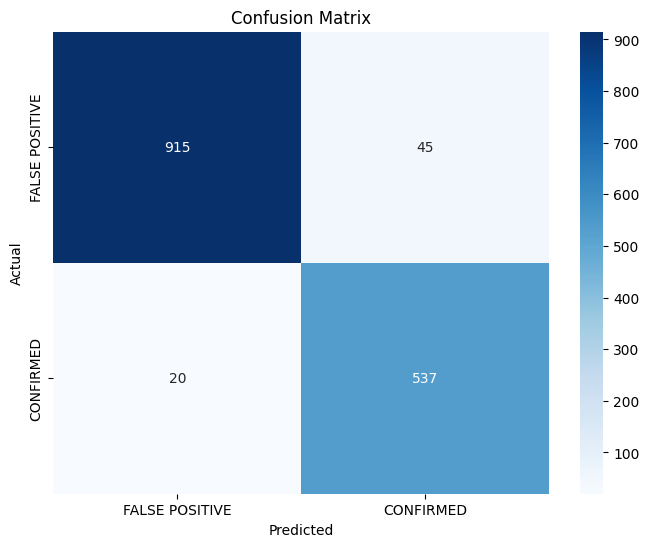

In [10]:
labels = ['FALSE POSITIVE', 'CONFIRMED']

Y_pred_probs = model.predict(X_test)
Y_pred = (Y_pred_probs >= 0.5).astype(int).flatten()
Y_true = Y_test.values.astype(int).flatten() 

Y_pred_strings = [labels[i] for i in Y_pred]
Y_true_strings = [labels[i] for i in Y_true]

cm = confusion_matrix(Y_true_strings, Y_pred_strings, labels=labels)
print(classification_report(Y_true_strings, Y_pred_strings, target_names=labels))
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Inference
This section of the notebook uses the trained model to predict whether the candidate planets in the table will be confirmed or false positives.

In [11]:
filename = 'kepler_db.csv'

df = pd.read_csv(filename, comment='#')
cols_to_drop = [
    'rowid', 'kepid', 'kepoi_name', 'kepler_name', 'koi_vet_stat', 'koi_vet_date',
    'koi_pdisposition', 'koi_score', 'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 
    'koi_fpflag_ec', 'koi_disp_prov', 'koi_comment', 'koi_eccen', 'koi_eccen_err1', 
    'koi_eccen_err2', 'koi_longp', 'koi_longp_err1', 'koi_longp_err2', 'koi_ingress', 
    'koi_ingress_err1', 'koi_ingress_err2',  'koi_sma_err1', 'koi_sma_err2', 'koi_incl_err1', 
    'koi_incl_err2', 'koi_teq_err1', 'koi_teq_err2', 'koi_limbdark_mod', 'koi_ldm_coeff4', 
    'koi_ldm_coeff3', 'koi_tce_plnt_num', 'koi_tce_delivname', 'koi_quarters', 
    'koi_bin_oedp_sig', 'koi_trans_mod', 'koi_model_dof', 'koi_model_chisq', 
    'koi_datalink_dvr', 'koi_datalink_dvs', 'koi_sage', 'koi_sage_err1', 'koi_sage_err2'
]
df_clean = df.drop(columns=cols_to_drop).reset_index(drop=True)

## Data preprocessing

In [12]:
Y = df_clean['koi_disposition'].map({'FALSE POSITIVE': 0, 'CONFIRMED': 1})
X = df_clean.drop(columns=['koi_disposition'])
X_filled = X.fillna(0)
X_encoded = pd.get_dummies(X_filled, drop_first=False).astype(np.float32)

mask = Y.isna()
X_encoded = X_encoded[mask]
scaler = joblib.load('kepler_scaler.pkl')
X_scaled = scaler.transform(X_encoded).astype(np.float32)

## Predictions generation

In [13]:
labels = ['FALSE POSITIVE', 'CONFIRMED']
model = keras.models.load_model('kepler.keras')
pred_org = model.predict(X_scaled)
pred = (pred_org >= 0.5).astype(int).flatten()

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step 


## Saving predictions to file

In [ ]:
candidates_meta = df.loc[mask, ['kepid', 'kepoi_name']]

with open('kepler_predictions.csv', 'w', encoding="utf-8") as f:
    f.write('kepid,kepoi_name,koi_disposition_pred,koi_disposition_pred_value\n')
    for i, (_, row) in enumerate(candidates_meta.iterrows()):
        f.write(f"{row['kepid']},{row['kepoi_name']},{labels[pred[i]]},{pred_org[i][0]}\n")

# Kepler exoplanet candidates export to Celestia
This section of the notebook processes the **Kepler exoplanet catalog** to generate `.stc`, `.ssc`, and `.cel` files compatible with **Celestia**.

## Definition of constants and functions

In [ ]:
G = 6.67430e-11  # gravitational constant (m^3 kg^-1 s^-2)
R_sun = 6.957e8  # solar radius (m)
L_sun = 3.828e26  # solar luminosity (W)
sigma = 5.670374419e-8  # Stefan–Boltzmann constant

def estimate_distance(row):
    try:
        R = row["koi_srad"] * R_sun
        T = row["koi_steff"]
        m = row["koi_kepmag"]
        
        # Luminosity
        L = 4 * np.pi * R**2 * sigma * T**4
        # Absolute magnitude
        M = 4.74 - 2.5 * np.log10(L / L_sun)
        # Distance (pc → ly)
        d_pc = 10 ** ((m - M + 5) / 5)
        return d_pc * 3.26156
    except KeyError:
        return np.nan

def generate_star(star_id, star_name, ra, dec, distance_ly, appmag, spectral_type):
    entry = ''
    entry += f'{star_id} "{star_name}" {{\n'
    entry += f'    RA {ra:.6f}\n'
    entry += f'    Dec {dec:.6f}\n'
    entry += f'    Distance {distance_ly:.2f}\n'
    entry += f'    SpectralType "{spectral_type}"\n'
    entry += f'    AppMag {appmag:.2f}\n'
    entry += '}\n\n'
    return entry

textures = [
    'GJ_504_b.jpg','HAT-P-11_b.jpg','Kepler-452_b.jpg','Proxima_Cen_b.jpg',
    'HD_189733_b.jpg','Kepler-7_b.jpg','YZ_Cet_d.jpg','Kepler-22_b.jpg',
    'OGLE-2005-BLG-390L_b.jpg','exo-class1.*','exo-class2.*','exo-class3.*',
    'exo-class4.*','exo-class5.*','venuslike.*','asteroid.*'
]

def generate_planet(star_name, planet_name, radius_km, period, semimajoraxis, eccentricity, inclination, distance, confidence, temperature):
    entry = ''
    texture = rand.choice(textures)
    entry += f'"{planet_name}" "{star_name}"\n'
    entry += '{\n'
    entry += '    Class "Planet"\n'
    entry += f'    Radius {radius_km:.2f}\n'
    entry += f'    Texture "{texture}"\n'
    if not (pd.isna(period) and pd.isna(semimajoraxis)):
        entry += '    EllipticalOrbit\n'
        entry += '    {\n'
        if not pd.isna(period):
            entry += f'        Period {period:.6f}\n'
        if not pd.isna(semimajoraxis):
            entry += f'        SemiMajorAxis {semimajoraxis:.6f}\n'
        entry += f'        Eccentricity {0.0 if pd.isna(eccentricity) else eccentricity:.6f}\n'
        entry += f'        Inclination {0.0 if pd.isna(inclination) else inclination:.6f}\n'
        # entry += f'        Distance "Approx. {distance:.6f} light years away from Earth"\n'
        # entry += f'        Confidence {int(confidence*100)}%\n'
        # entry += f'        Temperature {temperature}\n'
        entry += '    }\n'
    entry += '}\n\n'
    return entry

def generate_script_entry(planet_name, star_name, distance_ly, pred, value):
    text = f'Planet: {planet_name}\nApprox. {round(distance_ly,2)} light years away from Earth\n'
    if str(pred).upper() == "CONFIRMED":
        text += "Prediction: Real exoplanet\n"
        text += f'Confidence: {int(value*100)}%'
    elif str(pred).upper() == "FALSE POSITIVE":
        text += 'Prediction: False positive\n'
        text += f'Confidence: {int((1-value)*100)}%'
    else:
        text += "Prediction: unknown\n"
    entry = ''
    entry += f'select {{object "{star_name}"}}\n'
    entry += f'select {{object "{planet_name}"}}\n'
    entry += 'goto { time 6 distance 5 }\n'
    entry += 'wait { duration 6 }\n'
    entry += f'print {{ text "{text}"\n'
    entry += '         origin "top"\n'
    entry += '         row 5\n'
    entry += '         column -8\n'
    entry += '         duration 6 }\n'
    entry += 'orbit {duration 6 rate 60 axis [0 1 0] }\n\n'
    return entry

## Folder structure declaration

In [16]:
kepler_file = "kepler_db.csv"
kepler_predictions_file = "kepler_predictions.csv"
local_extras = "extras"
os.makedirs(local_extras, exist_ok=True)
scripts_dir = os.path.join(local_extras, "Scripts")
os.makedirs(scripts_dir, exist_ok=True)
print("Folder structure ready.")

Folder structure ready.


## Loading predictions from file

In [17]:
df_kepler = pd.read_csv(kepler_file, comment="#")
df_kepler_candidates = df_kepler[df_kepler["koi_disposition"] == "CANDIDATE"].copy()
kepler_predictions = pd.read_csv(kepler_predictions_file)
kepler_predictions = kepler_predictions[kepler_predictions["koi_disposition_pred"] == "CONFIRMED"].copy()
df_kepler_candidates = df_kepler_candidates.merge(
    kepler_predictions[["kepid", "koi_disposition_pred", "koi_disposition_pred_value"]],
    on="kepid", how="inner"
)
df_kepler_candidates["distance_ly"] = df_kepler_candidates.apply(estimate_distance, axis=1)

## Generating host stars catalog

In [ ]:

kepler_stars_stc_path = os.path.join(local_extras, "koi_hosts.stc")
with open(kepler_stars_stc_path, "w", encoding="utf-8") as f:
    for _, row in df_kepler_candidates.iterrows():
        entry = generate_star(
            star_id=int(row["kepid"]),
            star_name=f'Star-{row["kepoi_name"]}',
            ra=row["ra"],
            dec=row["dec"],
            distance_ly=row['distance_ly'],
            appmag=12,
            spectral_type="G0"
        )
        f.write(entry)
print(f"STC file generated: {kepler_stars_stc_path}")

STC file generated: extras/koi_hosts.stc


## Generating candidate exoplanets catalog

In [ ]:

kepler_planets_ssc_path = os.path.join(local_extras, "koi_candidates.ssc")
with open(kepler_planets_ssc_path, "w", encoding="utf-8") as f:
    for _, row in df_kepler_candidates.iterrows():
        radius_km = row["koi_prad"] * 6378
        entry = generate_planet(
            star_name=f'Star-{row["kepoi_name"]}',
            planet_name=row["kepoi_name"],
            radius_km=radius_km,
            period=row["koi_period"],
            semimajoraxis=row["koi_sma"],
            eccentricity=row["koi_eccen"],
            inclination=row["koi_incl"],
            distance=row['distance_ly'],
            confidence=row['koi_disposition_pred_value'],
            temperature=row['koi_teq']
        )
        f.write(entry)
print(f"SSC file generated: {kepler_planets_ssc_path}")

SSC file generated: extras/koi_candidates.ssc


## Generating Kepler visualizer script

In [ ]:
kepler_cel_file_path = os.path.join(scripts_dir, "koi_candidates.cel")
with open(kepler_cel_file_path, "w", encoding="utf-8") as f_cel:
    f_cel.write("{\n")
    f_cel.write('select {object "Earth"}\n')
    f_cel.write('changedistance {duration 8 rate 4}\n')

    for idx, row in df_kepler_candidates.iterrows():
        entry = generate_script_entry(
                                    planet_name=row["kepoi_name"],
                                    star_name=f'Star-{row["kepoi_name"]}',
                                    distance_ly = row["distance_ly"],
                                    pred=str(row.get("koi_disposition_pred", "unknown")),
                                    value=float(row.get("koi_disposition_pred_value"))
                                    )
        f_cel.write(entry)
    f_cel.write("}\n")

print(f"CEL script generated: {kepler_cel_file_path}")

CEL script generated: extras/Scripts/koi_candidates.cel
